# Código Auxiliar

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import feets
import light_curve.feets_patch

from catalog.catalog_loader import CatalogLoader
from light_curve.light_curve import LightCurve
from light_curve.gp_wrapper import ScikitGPWrapper
from typing import Optional

## Funciones auxiliares

### Graficación

In [2]:
# Auxiliary plotting functions.


# Given a light curve, plots magnitude vs HJD.
def plot_chronological(lc: LightCurve):
    fig, ax = plt.subplots(figsize=(12, 4))

    ax.errorbar(
        lc.time, lc.mag, lc.err, ls="", marker="o", color="tab:blue", ecolor="tab:red"
    )

    ax.set_title(f"Light Curve")
    ax.set_ylabel("Magnitude")
    ax.set_xlabel("HJD")

    ax.invert_yaxis()
    fig.tight_layout()


# Given a periodic light curve, plots magnitude vs period in two phases.
def plot_periodic(lc: LightCurve):
    # duplicate the values in two phases
    phase = np.hstack((lc.phase, lc.phase + 1))
    pmag = np.hstack((lc.pmag, lc.pmag))
    perr = np.hstack((lc.perr, lc.perr))

    # plot the folded light curve
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.errorbar(
        phase, pmag, perr, ls="", marker="o", ecolor="tab:blue", color="tab:red"
    )
    ax.set_title(f"Folded Light Curve")
    ax.set_ylabel("Magnitude")
    ax.set_xlabel("Phase")
    ax.invert_yaxis()

    fig.tight_layout()

    return ax


# Given a LightCurve plots the 95% confidence interval of the GP in one phase.
def plot_gp(
    lc: LightCurve, fig: Optional[plt.Figure] = None, ax: Optional[plt.Axes] = None
):
    lc._train()
    X = lc.phase.reshape(-1, 1)
    X_pred = np.linspace(0, 1, 100).reshape(-1, 1)
    y = lc.pmag
    mean_prediction, std_prediction = lc.model.predict(X_pred, return_std=True)

    mean_prediction += lc.background_level

    if fig is None:
        fig = plt.figure()

    if ax is None:
        ax = plt.subplot(111)

    ax.plot(X, y, linestyle="none")
    ax.errorbar(
        X[: len(lc.orig_hjd)],
        y[: len(lc.orig_hjd)],
        lc.perr[: len(lc.orig_hjd)],
        linestyle="None",
        color="tab:blue",
        marker=".",
        markersize=10,
        label="Observations",
    )

    # Plot synthetic points in a different color.
    ax.errorbar(
        X[len(lc.orig_hjd) :],
        y[len(lc.orig_hjd) :],
        lc.perr[len(lc.orig_hjd) :],
        linestyle="None",
        color="tab:red",
        marker=".",
        markersize=10,
        label="Synthetic",
    )

    ax.plot(X_pred, mean_prediction, label="Mean prediction")
    ax.fill_between(
        X_pred.ravel(),
        mean_prediction - 1.96 * std_prediction,
        mean_prediction + 1.96 * std_prediction,
        color="tab:orange",
        alpha=0.5,
        label=r"95% confidence interval",
    )
    return ax

# Aplicación de GP

## Obtención de los datos

In [3]:
# Get the catalogs.
loader = CatalogLoader("../catalog")
b278_lc = loader.get_lc("b278")
b278_features = loader.get_features("b278")

# Filter RRLyraes from the catalogs.
periodic_star_types = ["RRLyr-RRab", "RRLyr-RRc", "RRLyr-RRd"]
b278_features = b278_features[b278_features["vs_type"].isin(periodic_star_types)]
b278_lc = b278_lc[b278_lc.bm_src_id.isin(b278_features.id.to_numpy())]

# Select a star.
star = b278_features.iloc[8]

# Get the observations for the star.
light_curve = b278_lc[b278_lc.bm_src_id == star.id]

## Sensibilidad al ruido

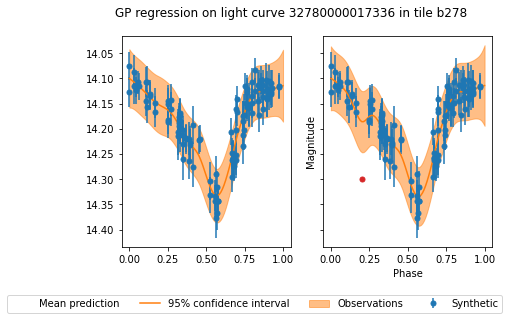

In [7]:
lc = LightCurve(light_curve, star.PeriodLS, star.id, model=ScikitGPWrapper())
fig, axs = plt.subplots(1, 2, sharey=True)

plot_gp(lc, fig, axs[0])

lc.phase = np.append(lc.phase, 0.2)
lc.pmag = np.append(lc.pmag, 14.3)
lc.perr = np.append(lc.perr, 0.002)
plot_gp(lc, fig, axs[1])

plt.xlabel("Phase")
plt.ylabel("Magnitude")
plt.gca().invert_yaxis()

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(
    labels,
    loc="lower right",
    bbox_to_anchor=(1, -0.1),
    ncol=len(labels),
    bbox_transform=fig.transFigure,
)
fig.suptitle(f"GP regression on light curve {lc.id} in tile b278")

fig.tight_layout();